In [4]:

!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
#!kaggle competitions download -c dataset_name -p "/content/drive/MyDrive/Colab Notebooks"
# For other datasets
!kaggle datasets download -d vijayuv/onlineretail -p "/content/drive/MyDrive/Colab Notebooks"



  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\banut\anaconda3\envs\nltk\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\banut\\AppData\\Local\\Temp\\pip-install-28yg445x\\lxml_a1bb660b930c4eb7a83e5fd3087845f9\\setup.py'"'"'; __file__='"'"'C:\\Users\\banut\\AppData\\Local\\Temp\\pip-install-28yg445x\\lxml_a1bb660b930c4eb7a83e5fd3087845f9\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\banut\AppData\Local\Temp\pip-wheel-dnpzo0fv'
       cwd: C:\Users\banut\AppData\Local\Temp\pip-install-28yg445x\lxml_a1bb660b930c4eb7a83e5fd3087845f9\
  Complete output (77 lines):
  Building lxml version 4.0.0.
  Building without Cython.
  ERROR: b"'xslt-config' is not recognized as an internal or external command,\r\noperable program or batch file.\r\n"
  ** make sure the development packages of

onlineretail.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! unzip "/content/drive/MyDrive/Colab Notebooks/onlineretail.zip"

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import datetime
from datetime import datetime

In [7]:
#some clustering libraries
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [8]:
df=pd.read_csv('OnlineRetail.csv')
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df.shape #number of rows and columns

(541909, 8)

In [10]:
df.info() # count, and data types of each feauture

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
df.Country.unique()  #which countries there are

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [12]:
def display_missing(df):  #find out missing values per each column
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum())) #provide blank space, and fill with the value of sum of empty cells
      #  print('\n') # go to next line
display_missing(df)

InvoiceNo column missing values: 0
StockCode column missing values: 0
Description column missing values: 1454
Quantity column missing values: 0
InvoiceDate column missing values: 0
UnitPrice column missing values: 0
CustomerID column missing values: 135080
Country column missing values: 0


In [13]:
df_corr=df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'CustomerID']   #VERY LOW CORRELATION  

,Feature 1,Feature 2,Correlation Coefficient
2,CustomerID,CustomerID,1.00000
4,CustomerID,UnitPrice,0.00456
6,CustomerID,Quantity,0.00360


In [14]:
df_corr=df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_corr[df_corr['Feature 1'] == 'UnitPrice']   #VERY LOW CORRELATION 

,Feature 1,Feature 2,Correlation Coefficient
1,UnitPrice,UnitPrice,1.000000
3,UnitPrice,CustomerID,0.004560
8,UnitPrice,Quantity,0.001235


In [15]:
#creating a start date of shopping transactions
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df.mindate = df['InvoiceDate'].min()
df['mindate'] = np.nan
df['mindate'] = pd.to_datetime(df['mindate'], format='%d-%m-%Y %H:%M')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   mindate      0 non-null       datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 37.2+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,mindate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,NaT
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,NaT
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,NaT
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,NaT
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,NaT


In [16]:
df['month']=pd.DatetimeIndex(df['InvoiceDate']).month
df['year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df['dow'] = pd.DatetimeIndex(df['InvoiceDate']).dayofweek
df.tail(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   mindate      0 non-null       datetime64[ns]
 9   month        541909 non-null  int64         
 10  year         541909 non-null  int64         
 11  dow          541909 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 49.6+ MB


In [17]:
np.unique(df.dow.values)  #one day of week value is missing from the original data, nothing to do, ignore and continue

array([0, 1, 2, 3, 4, 6], dtype=int64)

In [18]:
df["mindate"] = pd.Timestamp("01-12-2010 8:26")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   mindate      541909 non-null  datetime64[ns]
 9   month        541909 non-null  int64         
 10  year         541909 non-null  int64         
 11  dow          541909 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(4), object(4)
memory usage: 49.6+ MB


In [19]:
maxdate = max(df['InvoiceDate'])
df['dp'] = maxdate - df['InvoiceDate']
df['days'] =df['InvoiceDate'] - df['mindate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,mindate,month,year,dow,dp,days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373 days 04:24:00,323 days
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373 days 04:24:00,323 days
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373 days 04:24:00,323 days
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373 days 04:24:00,323 days
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373 days 04:24:00,323 days


In [20]:
df['dp'] = pd.to_numeric(df['dp'].dt.days, downcast='integer')
df['days'] = pd.to_numeric(df['days'].dt.days, downcast='integer')
df['revenue']= df ['Quantity']* df['UnitPrice']
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,mindate,month,year,dow,dp,days,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373,323,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-01-12 08:26:00,12,2010,2,373,323,20.34


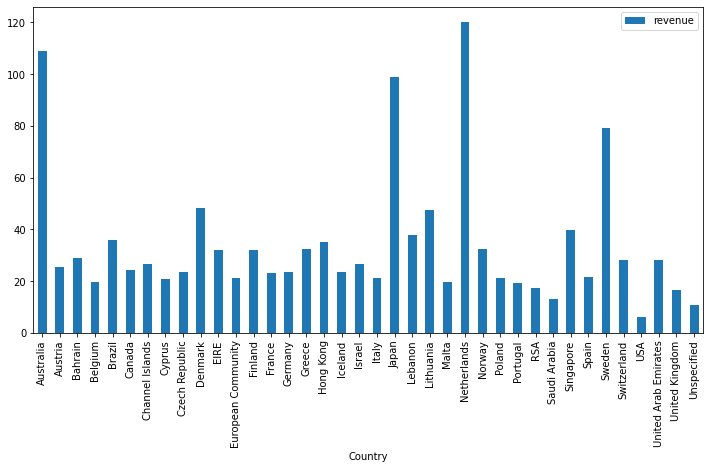

In [21]:
import matplotlib.pyplot as plt
c_pivot=df.pivot_table(index='Country', values='revenue')
c_pivot.plot.bar(figsize=(12,6))
plt.show()

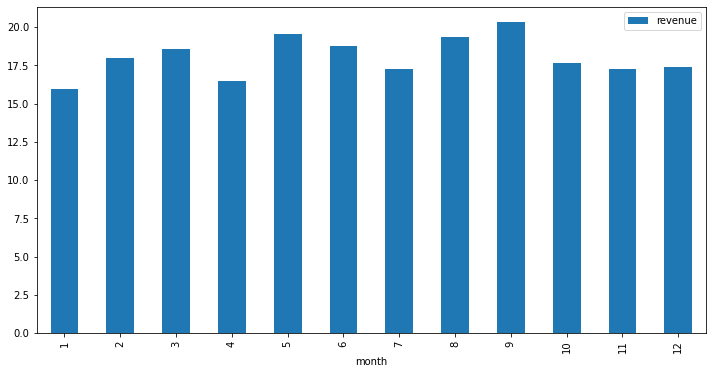

In [779]:
import matplotlib.pyplot as plt
c_pivot=df.pivot_table(index='month', values='revenue')
c_pivot.plot.bar(figsize=(12,6))
plt.show()

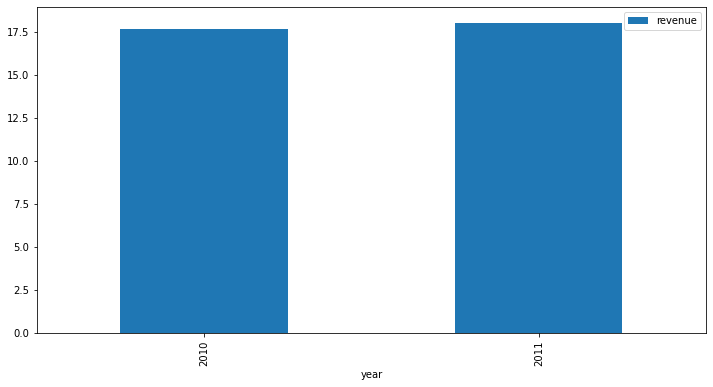

In [780]:
import matplotlib.pyplot as plt
c_pivot=df.pivot_table(index='year', values='revenue')
c_pivot.plot.bar(figsize=(12,6))
plt.show()

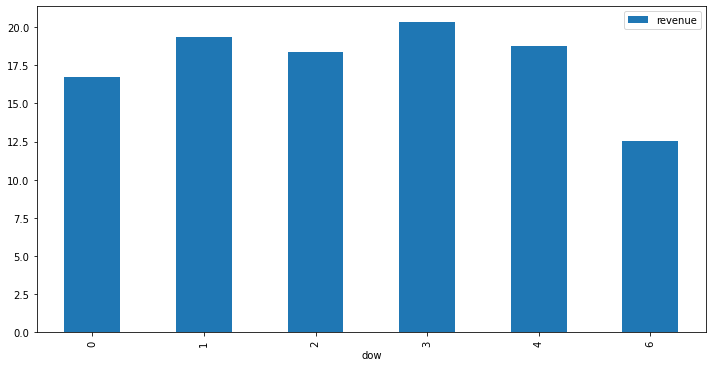

In [781]:
# 1 day of week is missing from the data
import matplotlib.pyplot as plt
c_pivot=df.pivot_table(index='dow', values='revenue')
c_pivot.plot.bar(figsize=(12,6))
plt.show()

In [782]:
df.info()  #final datatypes after conversions and adding new columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
 8   mindate      541909 non-null  datetime64[ns]
 9   month        541909 non-null  int64         
 10  year         541909 non-null  int64         
 11  dow          541909 non-null  int64         
 12  dp           541909 non-null  int16         
 13  days         541909 non-null  int16         
 14  revenue      541909 non-null  float64       
dtypes: datetime64[ns](2), float64(3), 

Quantity         AxesSubplot(0.125,0.125;0.0731132x0.755)
UnitPrice     AxesSubplot(0.212736,0.125;0.0731132x0.755)
CustomerID    AxesSubplot(0.300472,0.125;0.0731132x0.755)
days          AxesSubplot(0.388208,0.125;0.0731132x0.755)
revenue       AxesSubplot(0.475943,0.125;0.0731132x0.755)
month         AxesSubplot(0.563679,0.125;0.0731132x0.755)
dow           AxesSubplot(0.651415,0.125;0.0731132x0.755)
dtype: object

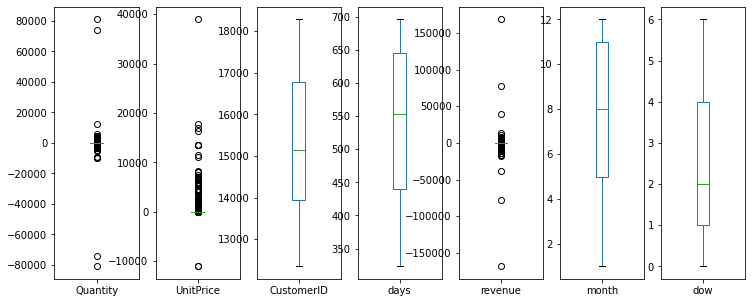

In [783]:
#quantity , price and revenue features have a lot of outliers but I will not remove them, they happen naturally
boxplot_cols=['Quantity', 'UnitPrice', 'CustomerID','days', 'revenue', 'month', 'dow', 'Country', 'InvoiceNo']
df[boxplot_cols].plot(kind='box', subplots=True, layout=(1,9), figsize=(16,5))

In [784]:
corr=df[['Quantity', 'UnitPrice', 'days', 'revenue','CustomerID' , 'month', 'dow', 'Country']].corr()  #only correlation between Quantity and revenue--makes sense
corr

,Quantity,UnitPrice,days,revenue,CustomerID,month,dow
Quantity,1.000000,-0.001235,0.000658,0.886681,-0.003600,-0.001116,-0.000904
UnitPrice,-0.001235,1.000000,-0.004547,-0.162029,-0.004560,-0.000497,-0.007310
days,0.000658,-0.004547,1.000000,0.000338,-0.000699,0.600329,0.029152
revenue,0.886681,-0.162029,0.000338,1.000000,-0.002274,0.000141,-0.002458
CustomerID,-0.003600,-0.004560,-0.000699,-0.002274,1.000000,0.030612,0.020822
month,-0.001116,-0.000497,0.600329,0.000141,0.030612,1.000000,0.040045
dow,-0.000904,-0.007310,0.029152,-0.002458,0.020822,0.040045,1.000000


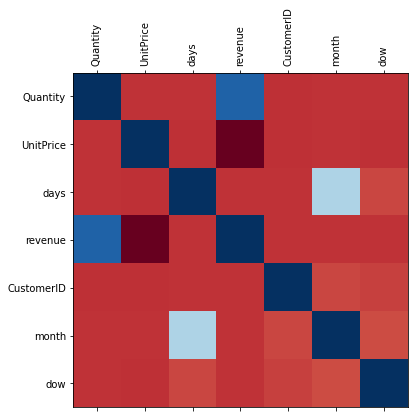

In [785]:
fig=plt.figure(figsize=(6,6))
plt.matshow(corr, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
plt.yticks(range(len(corr.columns)), corr.columns);  #only correlation between Quantity and revenue--makes sense

In [786]:
df.describe()

,Quantity,UnitPrice,CustomerID,month,year,dow,dp,days,revenue
count,541909.000000,541909.000000,406829.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,15287.690570,7.553128,2010.921609,2.431277,157.403319,537.994966,17.987795
std,218.081158,96.759853,1713.600303,3.509055,0.268787,1.844709,115.883491,115.877117,378.810824
min,-80995.000000,-11062.060000,12346.000000,1.000000,2010.000000,0.000000,0.000000,323.000000,-168469.600000
25%,1.000000,1.250000,13953.000000,5.000000,2011.000000,1.000000,51.000000,440.000000,3.400000
50%,3.000000,2.080000,15152.000000,8.000000,2011.000000,2.000000,142.000000,553.000000,9.750000
75%,10.000000,4.130000,16791.000000,11.000000,2011.000000,4.000000,256.000000,645.000000,17.400000
max,80995.000000,38970.000000,18287.000000,12.000000,2011.000000,6.000000,373.000000,696.000000,168469.600000


In [787]:
df = df[(df.UnitPrice>0) & (df.Quantity>0)]  #remove negative Quantities and prices
df.describe()

,Quantity,UnitPrice,CustomerID,month,year,dow,dp,days,revenue
count,530104.000000,530104.000000,397884.000000,530104.000000,530104.000000,530104.000000,530104.000000,530104.000000,530104.000000
mean,10.542037,3.907625,15294.423453,7.560611,2010.921751,2.436626,157.124410,538.273671,20.121871
std,155.524124,35.915681,1713.141560,3.508496,0.268563,1.850651,115.927848,115.921079,270.356743
min,1.000000,0.001000,12346.000000,1.000000,2010.000000,0.000000,0.000000,323.000000,0.001000
25%,1.000000,1.250000,13969.000000,5.000000,2011.000000,1.000000,51.000000,440.000000,3.750000
50%,3.000000,2.080000,15159.000000,8.000000,2011.000000,2.000000,141.000000,554.000000,9.900000
75%,10.000000,4.130000,16795.000000,11.000000,2011.000000,4.000000,256.000000,645.000000,17.700000
max,80995.000000,13541.330000,18287.000000,12.000000,2011.000000,6.000000,373.000000,696.000000,168469.600000


In [788]:
# Remove duplicate items 
df = df[~df.duplicated()]
df.describe()

,Quantity,UnitPrice,CustomerID,month,year,dow,dp,days,revenue
count,524878.000000,524878.000000,392692.000000,524878.000000,524878.000000,524878.000000,524878.000000,524878.000000,524878.000000
mean,10.616600,3.922573,15287.843865,7.552237,2010.921904,2.429138,157.323134,538.075208,20.275399
std,156.280031,36.093028,1713.539549,3.508164,0.268323,1.845795,115.842046,115.835370,271.693566
min,1.000000,0.001000,12346.000000,1.000000,2010.000000,0.000000,0.000000,323.000000,0.001000
25%,1.000000,1.250000,13955.000000,5.000000,2011.000000,1.000000,51.000000,440.000000,3.900000
50%,4.000000,2.080000,15150.000000,8.000000,2011.000000,2.000000,142.000000,554.000000,9.920000
75%,11.000000,4.130000,16791.000000,11.000000,2011.000000,4.000000,256.000000,645.000000,17.700000
max,80995.000000,13541.330000,18287.000000,12.000000,2011.000000,6.000000,373.000000,696.000000,168469.600000


In [789]:
def display_missing(df):  #find out missing values per each column  --> CustomerID and description columns have null
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum())) #provide blank space, and fill with the value of sum of empty cells
      #  print('\n') # go to next line
display_missing(df)

InvoiceNo column missing values: 0
StockCode column missing values: 0
Description column missing values: 0
Quantity column missing values: 0
InvoiceDate column missing values: 0
UnitPrice column missing values: 0
CustomerID column missing values: 132186
Country column missing values: 0
mindate column missing values: 0
month column missing values: 0
year column missing values: 0
dow column missing values: 0
dp column missing values: 0
days column missing values: 0
revenue column missing values: 0


In [790]:
dfwithCI=df.copy()
id(dfwithCI)

2163337235856

In [791]:
id(df)  #df and dfwithCI have different memory and space

2164720705744

In [792]:
dfwithCI.shape

(524878, 15)

In [793]:
df = df[df.CustomerID.notnull()].copy() #remove rows with empty CusotmerIds, need to identfy the customer
df.describe()

,Quantity,UnitPrice,CustomerID,month,year,dow,dp,days,revenue
count,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865,7.601871,2010.934631,2.606911,151.204379,544.242641,22.631500
std,180.492832,22.241836,1713.539549,3.415015,0.247177,1.923929,112.691582,112.672325,311.099224
min,1.000000,0.001000,12346.000000,1.000000,2010.000000,0.000000,0.000000,323.000000,0.001000
25%,2.000000,1.250000,13955.000000,5.000000,2011.000000,1.000000,49.000000,450.000000,4.950000
50%,6.000000,1.950000,15150.000000,8.000000,2011.000000,2.000000,131.000000,565.000000,12.450000
75%,12.000000,3.750000,16791.000000,11.000000,2011.000000,4.000000,246.000000,646.000000,19.800000
max,80995.000000,8142.750000,18287.000000,12.000000,2011.000000,6.000000,373.000000,696.000000,168469.600000


In [794]:
df = df[df.Description.notnull()].copy()
df.describe()

,Quantity,UnitPrice,CustomerID,month,year,dow,dp,days,revenue
count,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865,7.601871,2010.934631,2.606911,151.204379,544.242641,22.631500
std,180.492832,22.241836,1713.539549,3.415015,0.247177,1.923929,112.691582,112.672325,311.099224
min,1.000000,0.001000,12346.000000,1.000000,2010.000000,0.000000,0.000000,323.000000,0.001000
25%,2.000000,1.250000,13955.000000,5.000000,2011.000000,1.000000,49.000000,450.000000,4.950000
50%,6.000000,1.950000,15150.000000,8.000000,2011.000000,2.000000,131.000000,565.000000,12.450000
75%,12.000000,3.750000,16791.000000,11.000000,2011.000000,4.000000,246.000000,646.000000,19.800000
max,80995.000000,8142.750000,18287.000000,12.000000,2011.000000,6.000000,373.000000,696.000000,168469.600000


In [795]:
df['CustomerID'] = df['CustomerID'].astype(str)

In [796]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  object        
 8   mindate      392692 non-null  datetime64[ns]
 9   month        392692 non-null  int64         
 10  year         392692 non-null  int64         
 11  dow          392692 non-null  int64         
 12  dp           392692 non-null  int16         
 13  days         392692 non-null  int16         
 14  revenue      392692 non-null  float64       
dtypes: datetime64[ns](2), float64(2), 

In [797]:
#total revenue of transactions based on customerid
dfr = df.groupby('CustomerID')['revenue'].sum()
dfr = dfr.reset_index()
dfr.head()
dfr.shape

(4338, 2)

In [798]:
dfwithCIr=dfwithCI.groupby('CustomerID')['revenue'].sum()
dfwithCIr=dfwithCIr.reset_index()
dfwithCIr.shape

(4338, 2)

In [799]:
#calculate freq of purchase based on customerid
dff = df.groupby('CustomerID')['InvoiceNo'].count()
dff = dff.reset_index()
dff.columns = ['CustomerID', 'Frequency']
dff.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [800]:
dfwithCIf = dfwithCI.groupby('CustomerID')['InvoiceNo'].count()
dfwithCIf = dfwithCIf.reset_index()
dfwithCIf.columns = ['CustomerID', 'Frequency']
dfwithCIf.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [801]:
#combine freq and revenue datasets
dfrf = pd.merge(dfr, dff, on='CustomerID', how='inner')
dfrf.head()

,CustomerID,revenue,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [802]:
dfwithCIrf = pd.merge(dfwithCIr, dfwithCIf, on='CustomerID', how='inner')
dfwithCIrf.head()

,CustomerID,revenue,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [803]:
#calculate how recent was the last transaction
dfdp = df.groupby('CustomerID')['dp'].min()
dfdp = dfdp.reset_index()
dfdp.head()

,CustomerID,dp
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [804]:
dfwithCIdp = dfwithCI.groupby('CustomerID')['dp'].min()
dfwithCIdp = dfwithCIdp.reset_index()
dfwithCIdp.head()

,CustomerID,dp
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [805]:
#combine dfrf with dfrec
dfc = pd.merge(dfrf, dfdp, on='CustomerID', how='inner')
dfc.columns = ['CustomerID', 'revenue', 'frequency', 'daysprior']
dfc.describe()

,revenue,frequency,daysprior
count,4338.000000,4338.000000,4338.000000
mean,2048.688081,90.523744,91.536422
std,8985.230220,225.506968,100.014169
min,3.750000,1.000000,0.000000
25%,306.482500,17.000000,17.000000
50%,668.570000,41.000000,50.000000
75%,1660.597500,98.000000,141.000000
max,280206.020000,7676.000000,373.000000


In [806]:
dfwithCIc = pd.merge(dfwithCIrf, dfwithCIdp, on='CustomerID', how='inner')
dfwithCIc.columns = [ 'CustomerID', 'revenue', 'frequency', 'daysprior']  #drop customerid 
dfwithCIc.drop('CustomerID', axis=1, inplace=True)

In [807]:
dfwithCIc.head()
dfwithCIc.shape

(4338, 3)

array([[<AxesSubplot:title={'center':'frequency'}>]], dtype=object)

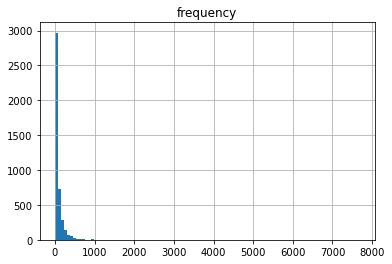

In [808]:
dfc.hist(column='frequency', bins=100)

array([[<AxesSubplot:title={'center':'revenue'}>]], dtype=object)

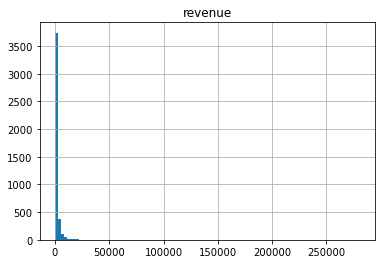

In [809]:
dfc.hist(column='revenue', bins=100)

array([[<AxesSubplot:title={'center':'daysprior'}>]], dtype=object)

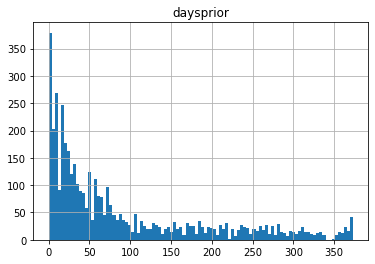

In [810]:
dfc.hist(column='daysprior', bins=100)

revenue         AxesSubplot(0.125,0.536818;0.227941x0.343182)
frequency    AxesSubplot(0.398529,0.536818;0.227941x0.343182)
daysprior    AxesSubplot(0.672059,0.536818;0.227941x0.343182)
dtype: object

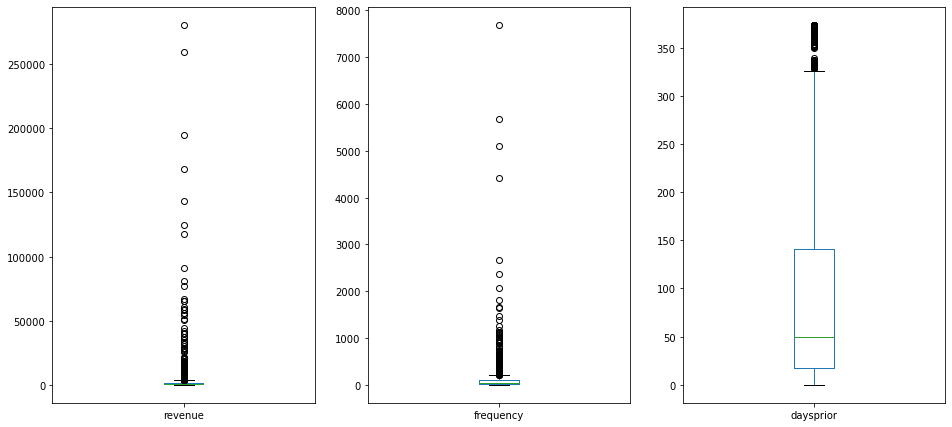

In [811]:
boxplot_cols=['revenue', 'frequency', 'daysprior']
dfc[boxplot_cols].plot(kind='box', subplots=True, layout=(2,3), figsize=(16,16))

In [812]:
dfc.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [813]:
dfcsecondanalysis=dfc.copy()
dfcsecondanalysis.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


TRY HIERARCHICAL CLUSTERING 
Hierarchical clustering is a super useful way of segmenting observations. 
The advantage of not having to pre-define the number of clusters gives it quite an edge over k-Means.

In [814]:
dfcthirdanalysiss=dfwithCIc.copy()
dfcthirdanalysiss.head()

,revenue,frequency,daysprior
0,77183.60,1,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [815]:
from sklearn.preprocessing import normalize
dfcthirdanalysis = normalize(dfcthirdanalysiss)
dfcthirdanalysis = pd.DataFrame(dfcthirdanalysis, columns=dfcthirdanalysiss.columns)
dfcthirdanalysis.head()

,revenue,frequency,daysprior
0,0.999991,0.000013,0.004211
1,0.999110,0.042190,0.000232
2,0.999005,0.017232,0.041133
3,0.999086,0.041497,0.010232
4,0.733938,0.037311,0.678191


In [817]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean')
model.fit(dfcthirdanalysis)

AgglomerativeClustering()

In [818]:
dfcthirdanalysis['Hierarchical_customer_labels']=model.labels_
dfcthirdanalysis.head()

,revenue,frequency,daysprior,Hierarchical_customer_labels
0,0.999991,0.000013,0.004211,0
1,0.999110,0.042190,0.000232,0
2,0.999005,0.017232,0.041133,0
3,0.999086,0.041497,0.010232,0
4,0.733938,0.037311,0.678191,1


In [819]:
dfcthirdanalysis.iloc[:,3]

0       0
1       0
2       0
3       0
4       1
       ..
4333    1
4334    1
4335    0
4336    0
4337    0
Name: Hierarchical_customer_labels, Length: 4338, dtype: int64

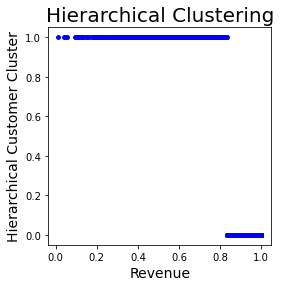

In [820]:
# Plotting resulting clusters
plt.figure(figsize=(4,4))
plt.scatter(dfcthirdanalysis.iloc[:,0],   dfcthirdanalysis.iloc[:,3], c='blue' , s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('Revenue',fontsize=14)
plt.ylabel('Hierarchical Customer Cluster',fontsize=14)
plt.show()

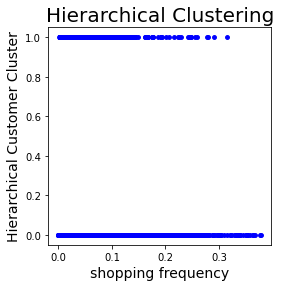

In [821]:
# Plotting resulting clusters
plt.figure(figsize=(4,4))
plt.scatter(dfcthirdanalysis.iloc[:,1],   dfcthirdanalysis.iloc[:,3], c='blue' , s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('shopping frequency',fontsize=14)
plt.ylabel('Hierarchical Customer Cluster',fontsize=14)
plt.show()

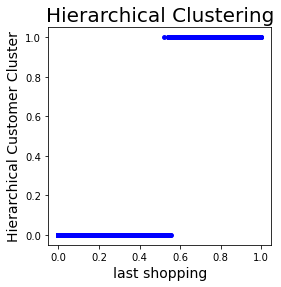

In [822]:
# Plotting resulting clusters
plt.figure(figsize=(4,4))
plt.scatter(dfcthirdanalysis.iloc[:,2],   dfcthirdanalysis.iloc[:,3], c='blue' , s=15)
plt.title('Hierarchical Clustering',fontsize=20)
plt.xlabel('last shopping',fontsize=14)
plt.ylabel('Hierarchical Customer Cluster',fontsize=14)
plt.show()

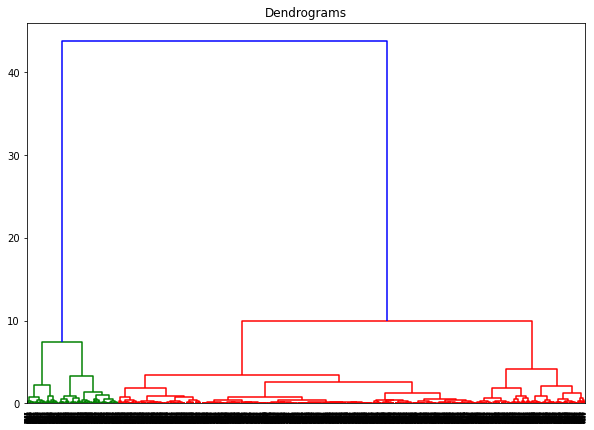

In [823]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(dfcthirdanalysis, method='ward'))  

this dendogram offers only two cluster when we cut around 60 but it is not good for business perspective so I still try 5 clusters instead of 2

In [824]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(dfcthirdanalysis)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

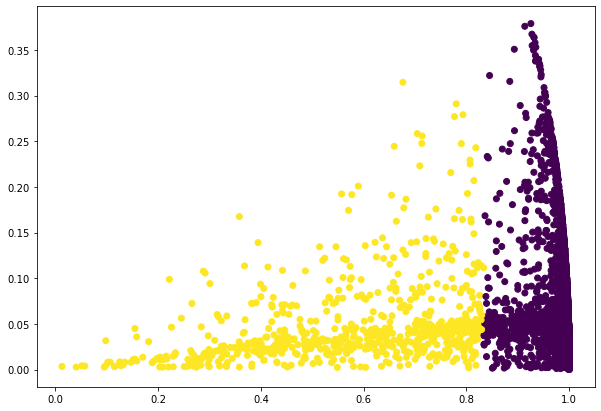

In [699]:
plt.figure(figsize=(10, 7))  
plt.scatter(dfcthirdanalysis['revenue'], dfcthirdanalysis['frequency'], c=cluster.labels_) 

In [825]:

dfcs4thanalysis.head()

,revenue,frequency,daysprior,dbscan_cluster
0,0.999991,0.000013,0.004211,0
1,0.999110,0.042190,0.000232,0
2,0.999005,0.017232,0.041133,0
3,0.999086,0.041497,0.010232,0
4,0.733938,0.037311,0.678191,0


In [827]:
dfcthirdanalysis.head()

,revenue,frequency,daysprior,Hierarchical_customer_labels
0,0.999991,0.000013,0.004211,0
1,0.999110,0.042190,0.000232,0
2,0.999005,0.017232,0.041133,0
3,0.999086,0.041497,0.010232,0
4,0.733938,0.037311,0.678191,1


If I force to get 5 clusters from hierarchical

In [891]:
dfcthirdanalysis2=dfcthirdanalysis.copy()

In [892]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(dfcthirdanalysis2)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

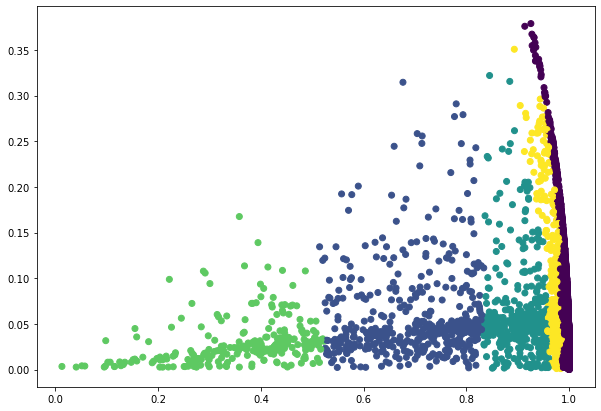

In [902]:
plt.figure(figsize=(10, 7))  
plt.scatter(dfcthirdanalysis2['revenue'], dfcthirdanalysis2['frequency'], c=cluster.labels_) 

In [899]:
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean')
model.fit(dfcthirdanalysis2)

AgglomerativeClustering(n_clusters=5)

In [900]:
dfcthirdanalysis2['Hierarchical_customer_labels']=model.labels_
dfcthirdanalysis2.head()

,revenue,frequency,daysprior,Hierarchical_customer_labels
0,0.999991,0.000013,0.004211,0
1,0.999110,0.042190,0.000232,0
2,0.999005,0.017232,0.041133,0
3,0.999086,0.041497,0.010232,0
4,0.733938,0.037311,0.678191,1


In [901]:
dfcthirdanalysis2['Hierarchical_customer_labels'].unique()

array([0, 1, 3, 4, 2], dtype=int64)

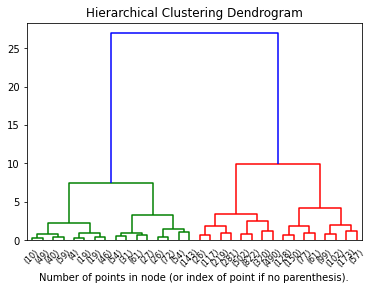

In [701]:
# ANOTHER dendogram again offering 2 clusters only, which is not good for business!!!


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X=dfcthirdanalysis[['revenue', 'frequency', 'daysprior']]

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

TRY DBSCAN CLUSTERING as we have different density clusters

In [702]:
from sklearn.cluster import DBSCAN

In [703]:
dfcs4thanalysiss=dfc.copy()

In [704]:
dfcs4thanalysiss.drop('CustomerID', axis=1, inplace=True)

In [705]:
dfc.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [706]:
from sklearn.preprocessing import normalize
dfcs4thanalysis = normalize(dfcs4thanalysiss)
dfcs4thanalysis = pd.DataFrame(dfcs4thanalysis, columns=dfcs4thanalysiss.columns)
dfcs4thanalysis.head()

,revenue,frequency,daysprior
0,0.999991,0.000013,0.004211
1,0.999110,0.042190,0.000232
2,0.999005,0.017232,0.041133
3,0.999086,0.041497,0.010232
4,0.733938,0.037311,0.678191


In [707]:
X=dfcs4thanalysis[['revenue', 'frequency']]

In [708]:
m=DBSCAN(eps=0.014473734767694877, min_samples=10)  
#When eps is chosen too small, most data will not be clustered at all (and labeled as -1 for “noise”). 
#When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluste
m.fit(X)

DBSCAN(eps=0.014473734767694877, min_samples=10)

THIS EPS VALUE IS CALCULATED BELOW

In [709]:
dfcs4thanalysis['dbscan_cluster']=m.labels_ 

In [710]:
dfcs4thanalysis.head()

,revenue,frequency,daysprior,dbscan_cluster
0,0.999991,0.000013,0.004211,0
1,0.999110,0.042190,0.000232,0
2,0.999005,0.017232,0.041133,0
3,0.999086,0.041497,0.010232,0
4,0.733938,0.037311,0.678191,0


In [711]:
dfcs4thanalysis.dbscan_cluster.value_counts()  #here -1 corresponds to noise!!!

 0    3802
-1     315
 1      86
 2      80
 3      41
 4      14
Name: dbscan_cluster, dtype: int64

<AxesSubplot:xlabel='revenue', ylabel='frequency'>

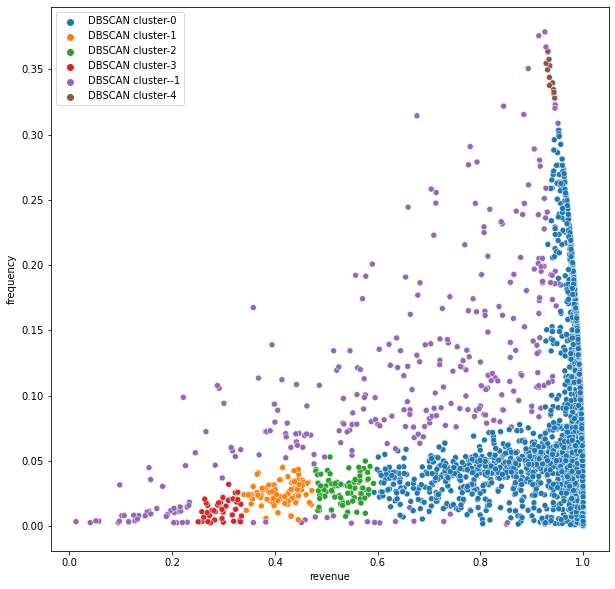

In [712]:
fig = plt.figure(figsize=(10, 10)) 
sns.scatterplot(x="revenue", y="frequency", data=dfcs4thanalysis,    hue=["DBSCAN cluster-{}".format(x) for x in dfcs4thanalysis['dbscan_cluster']])

HOW TO FIND IDEAL EPS VALUE: KNEE DISTANCE WILL BE CALCULATED

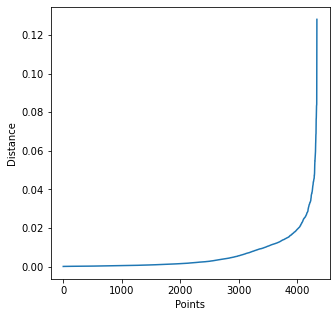

In [713]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

In [714]:
!pip install --upgrade kneed

0.014473734767694877


<Figure size 360x360 with 0 Axes>

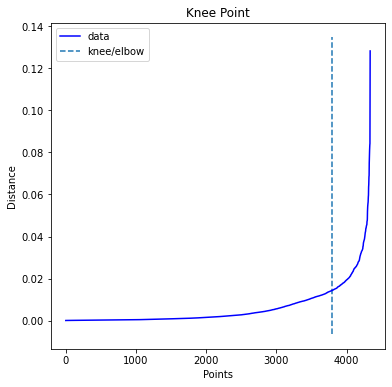

In [715]:
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

NOW We know that eps=0.014473734767694877 as given above line

In [716]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

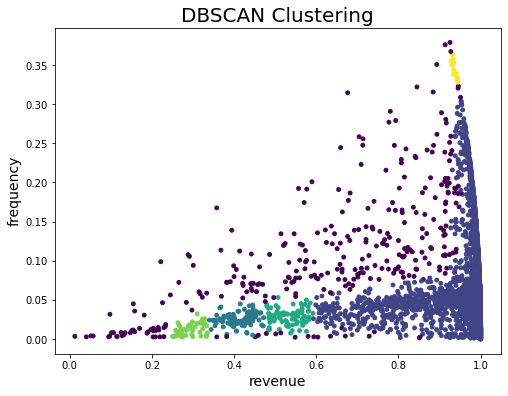

In [717]:
# Plotting resulting clusters

plt.figure(figsize=(8,6))
plt.scatter(x=dfcs4thanalysis["revenue"] , y=dfcs4thanalysis["frequency"],   c=dfcs4thanalysis['dbscan_cluster'],  s=15)
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('revenue',fontsize=14)
plt.ylabel('frequency',fontsize=14)
plt.show()

result of DBSCAN:  not very intuitive & too much noise 

In [718]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

Estimated number of clusters: 5
Estimated number of noise points: 1194
Silhouette Coefficient: 0.202


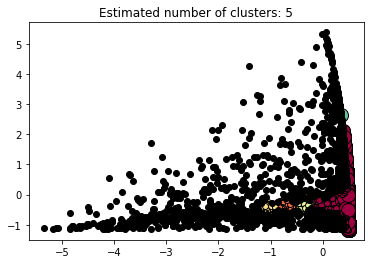

In [719]:

X=dfcthirdanalysis[['revenue', 'frequency', 'daysprior']]

# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
#X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)

X = StandardScaler().fit_transform(X)

# Compute DBSCAN
db = DBSCAN(eps=0.12, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [720]:
X=dfcthirdanalysis[['revenue', 'frequency', 'daysprior']]
X.shape

(4338, 3)

Number of clusters: 2
Silhouette Coefficient: 0.202


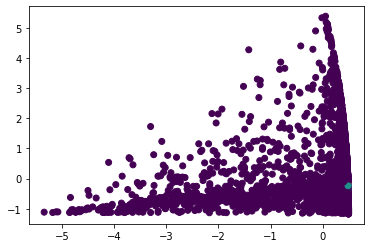

In [721]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


#X, y = make_circles(n_samples=750, factor=0.3, noise=0.1)
X = StandardScaler().fit_transform(X)
y_pred = DBSCAN(eps=0.014473734767694877, min_samples=20).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=y_pred)
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
#print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
#print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"  % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"  % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"      % metrics.silhouette_score(X, labels))

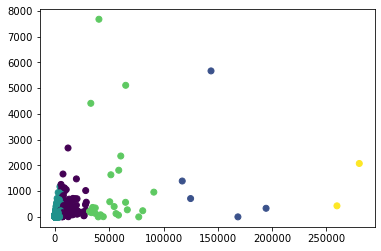

In [722]:
X = dfcsecondanalysis[['revenue', 'frequency', 'daysprior']].to_numpy()      

y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)  

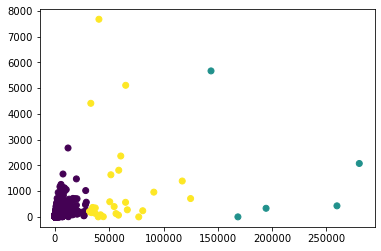

In [723]:
X = dfc[['revenue', 'frequency', 'daysprior']].to_numpy()      

y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)  

In [724]:
# Rescaling the attributes

dfc2 = dfc[[ 'revenue', 'frequency', 'daysprior']]

# Instantiate
scaler = StandardScaler()

# fit_transform
dfc3 = scaler.fit_transform(dfc2)
dfc3.shape

(4338, 3)

In [725]:
dfc3 = pd.DataFrame(dfc3)
dfc3.columns = ['revenue', 'frequency', 'daysprior']
dfc3.head()

,revenue,frequency,daysprior
0,8.363010,-0.397035,2.334574
1,0.251699,0.405694,-0.905340
2,-0.027988,-0.263986,-0.175360
3,-0.032406,-0.077717,-0.735345
4,-0.190812,-0.326075,2.174578


In [726]:
dfc.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


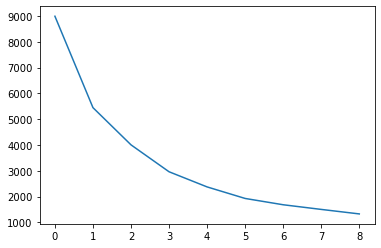

In [727]:
# Elbow-curve
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(dfc3)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)

In [728]:
# Silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(dfc3)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(dfc3, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.9312310483407636
For n_clusters=3, the silhouette score is 0.6022759587511283
For n_clusters=4, the silhouette score is 0.6002335437299007
For n_clusters=5, the silhouette score is 0.6165550700897563
For n_clusters=6, the silhouette score is 0.5901955556602421
For n_clusters=7, the silhouette score is 0.5228110540968849
For n_clusters=8, the silhouette score is 0.49900321962756494


#DO NOT KNOW how to integrate this piece to get the best iteration out of all based on Silhouette scores :(
best_result = (n_clusters, metric_score)
clusters = []
for M iterations:
    for 1 to N clusters:
        Kmeans(n_clusters)
        calculate metric_score
        if metric_score better than previous best:
            save cluster assignments
            update best_result
            


In [729]:
corr=dfc[['revenue', 'frequency', 'daysprior']].corr()  #medium correlation between revenue and frequency as expected
corr

,revenue,frequency,daysprior
revenue,1.000000,0.425282,-0.121831
frequency,0.425282,1.000000,-0.206444
daysprior,-0.121831,-0.206444,1.000000


In [730]:
dfctwo=dfc.copy()
dfctwo.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [731]:
dfcthree=dfc.copy()
dfcthree.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [919]:
from sklearn.preprocessing import normalize
dfcthree2 = normalize(dfcthree)
dfcthree2 = pd.DataFrame(dfcthree2, columns=dfcthree.columns)
dfcthree2.head()

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,0.157947,0.987439,0.000013,0.004158,0.000026
1,0.944040,0.329538,0.013916,0.000076,0.000229
2,0.989553,0.144028,0.002484,0.005930,0.000240
3,0.990005,0.140901,0.005852,0.001443,0.000241
4,0.999320,0.027059,0.001376,0.025003,0.000243


In [732]:
dfcfour=dfc.copy()
dfcfour.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [733]:
dfcfive=dfc.copy()
dfcfive.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [734]:
dfcsix=dfc.copy()
dfcsix.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [735]:
feature_names = dfc.columns

In [736]:
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=1500)
kmeans.fit(dfc)
kmeans.labels_
#assign created labels as ClusterNo
dfc['ClusterNo'] = kmeans.labels_
dfc['ClusterNo'].unique()
dfc.head(2)

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.6,1,325,2
1,12347.0,4310.0,182,1,0


In [737]:
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

Feature: 0, Score: 0.80683
Feature: 1, Score: 0.15229
Feature: 2, Score: 0.04089


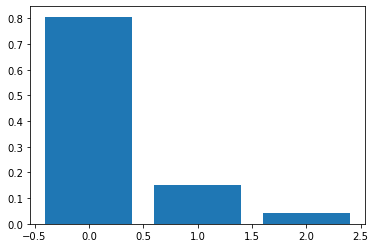

In [738]:
# random forest for feature importance on a classification problem   ---> SO REMOVE daysprior as it is not important
#The complete example of fitting a RandomForestClassifier and summarizing the calculated feature importance scores is listed below.
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
feature_cols = ['revenue', 'frequency', 'daysprior']
X = dfc[feature_cols] # Features
y = dfc.ClusterNo # Target variable
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

kmeans = KMeans(n_clusters=5, random_state=42, max_iter=50)
kmeans.fit(dfcsecondanalysis)
kmeans.labels_
#assign created labels as ClusterNo
dfcsecondanalysis['ClusterNo'] = kmeans.labels_
dfcsecondanalysis.head(2)

In [739]:
kmeans = KMeans(n_clusters=3, random_state=42, max_iter=1500)
kmeans.fit(dfc)
kmeans.labels_
#assign created labels as ClusterNo
dfc['ClusterNo'] = kmeans.labels_
dfc['ClusterNo'].unique()
dfc.head(2)

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.6,1,325,2
1,12347.0,4310.0,182,1,0


In [740]:
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=50)
kmeans.fit(dfctwo)
kmeans.labels_
#assign created labels as ClusterNo
dfctwo['ClusterNo'] = kmeans.labels_
dfctwo.head(2)

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.6,1,325,2
1,12347.0,4310.0,182,1,0


In [741]:
kmeans = KMeans(n_clusters=5, random_state=42, max_iter=50)
kmeans.fit(dfcthree)
kmeans.labels_
#assign created labels as ClusterNo
dfcthree['ClusterNo'] = kmeans.labels_
dfcthree.ClusterNo.head()

0    2
1    3
2    3
3    3
4    3
Name: ClusterNo, dtype: int32

In [920]:
kmeans = KMeans(n_clusters=5, random_state=42, max_iter=50)
kmeans.fit(dfcthree2)
kmeans.labels_
#assign created labels as ClusterNo
dfcthree2['ClusterNo'] = kmeans.labels_
dfcthree2.ClusterNo.head()

0    3
1    2
2    0
3    0
4    4
Name: ClusterNo, dtype: int32

In [742]:

dfcthree[["ClusterNo", "revenue"]].groupby("ClusterNo").sum()

,revenue
ClusterNo,
0,2014749.300
1,748699.070
2,1243098.290
3,4340798.914
4,539863.320


Text(0.5, 0, 'Cluster')

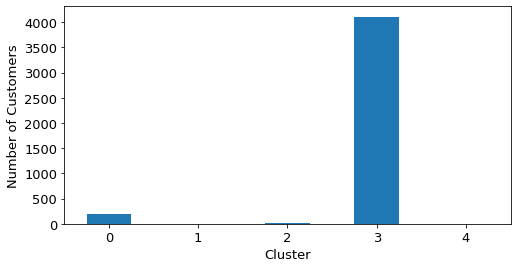

In [921]:
dfcthreegb = dfcthree.groupby(["ClusterNo"]).size()
dfcthreegb
ax = dfcthreegb.plot.bar(x='ClusterNo', rot=0, figsize=(8, 4), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Cluster', fontsize=13)

Text(0.5, 0, 'Cluster')

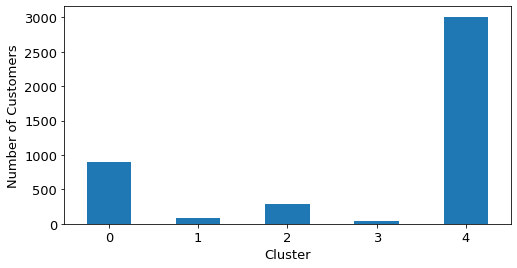

In [922]:
#What happens when we use normalized data for k means cluster = 5 clusters
dfcthree2gb = dfcthree2.groupby(["ClusterNo"]).size()
dfcthree2gb
ax = dfcthree2gb.plot.bar(x='ClusterNo', rot=0, figsize=(8, 4), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Cluster', fontsize=13)

Text(0.5, 0, 'Cluster')

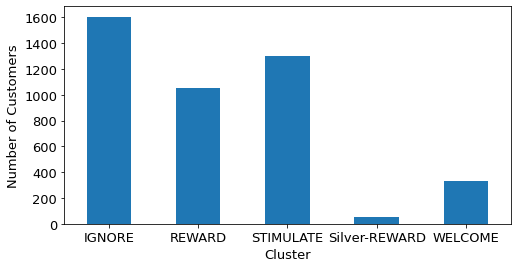

In [926]:
#Marketing clusters
dfcthree2gb = dfcsecondanalysis.groupby(["Segment"]).size()
dfcthree2gb
ax = dfcthree2gb.plot.bar(x='Segment', rot=0, figsize=(8, 4), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Cluster', fontsize=13)

Text(0.5, 0, 'Cluster')

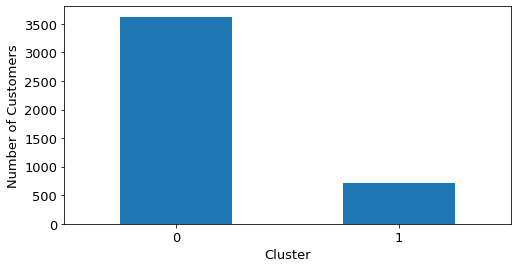

In [927]:
#What happens when we use normalized data for k means cluster = 5 clusters
dfcthree2gb = dfcthirdanalysis.groupby(["Hierarchical_customer_labels"]).size()
dfcthree2gb
ax = dfcthree2gb.plot.bar(x='Hierarchical_customer_labels', rot=0, figsize=(8, 4), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Cluster', fontsize=13)

Text(0.5, 0, 'Cluster')

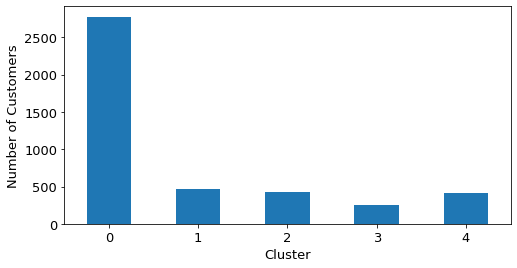

In [928]:
#What happens when we use normalized data for k means cluster = 5 clusters
dfcthree2gb = dfcthirdanalysis2.groupby(["Hierarchical_customer_labels"]).size()
dfcthree2gb
ax = dfcthree2gb.plot.bar(x='Hierarchical_customer_labels', rot=0, figsize=(8, 4), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Cluster', fontsize=13)

Text(0.5, 0, 'Cluster')

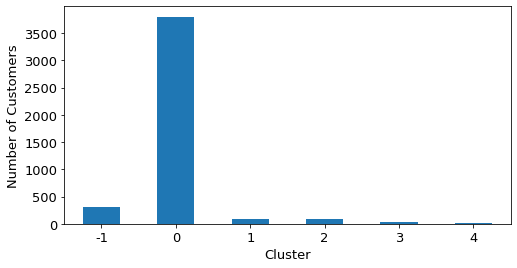

In [930]:
#What happens when we use normalized data for k means cluster = 5 clusters
dfcthree2gb = dfcs4thanalysis.groupby(["dbscan_cluster"]).size()
dfcthree2gb
ax = dfcthree2gb.plot.bar(x='dbscan_cluster', rot=0, figsize=(8, 4), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Cluster', fontsize=13)

In [744]:
dfcthree[["ClusterNo", "revenue"]].groupby("ClusterNo").describe()

revenue                                                       \
            count           mean           std        min          25%   
ClusterNo                                                                
0           197.0   10227.153807   5093.392395    5568.35    6717.3400   
1             5.0  149739.814000  31841.192074  117210.08  124914.5300   
2            24.0   51795.762083  16706.289720   31833.68   37148.0375   
3          4110.0    1056.155454   1121.508211       3.75     294.8875   
4             2.0  269931.660000  14530.139257  259657.30  264794.4800   

                                               
                  50%          75%        max  
ClusterNo                                      
0            8338.490   12076.1500   28882.44  
1          143711.170  168472.5000  194390.79  
2           51009.555   61734.4675   91062.38  
3             622.130    1405.4950    5739.46  
4          269931.660  275068.8400  280206.02

In [745]:
dfcthree[["ClusterNo", "frequency"]].groupby("ClusterNo").describe()

frequency                                                            \
              count         mean          std    min     25%     50%      75%   
ClusterNo                                                                       
0             197.0   348.177665   309.154185    4.0  159.00   303.0   440.00   
1               5.0  1623.600000  2320.411666    3.0  336.00   714.0  1395.00   
2              24.0  1157.833333  1936.109965    1.0  136.75   313.0  1131.50   
3            4110.0    69.510462    93.631425    1.0   16.00    38.0    87.00   
4               2.0  1253.500000  1163.190655  431.0  842.25  1253.5  1664.75   

                   
              max  
ClusterNo          
0          2677.0  
1          5670.0  
2          7676.0  
3          1263.0  
4          2076.0

In [746]:
dfcthree[["ClusterNo", "daysprior"]].groupby("ClusterNo").describe()

daysprior                                                        
              count       mean         std  min    25%   50%     75%    max
ClusterNo                                                                  
0             197.0  19.187817   32.171737  0.0   2.00   9.0   22.00  275.0
1               5.0   7.800000    9.418068  0.0   0.00   7.0    9.00   23.0
2              24.0  36.250000   84.461079  0.0   1.75   3.0   11.50  325.0
3            4110.0  95.473236  100.854399  0.0  19.00  53.0  150.75  373.0
4               2.0   0.500000    0.707107  0.0   0.25   0.5    0.75    1.0

In [747]:
dfcthree.describe()

,revenue,frequency,daysprior,ClusterNo
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,2048.688081,90.523744,91.536422,2.856385
std,8985.230220,225.506968,100.014169,0.631494
min,3.750000,1.000000,0.000000,0.000000
25%,306.482500,17.000000,17.000000,3.000000
50%,668.570000,41.000000,50.000000,3.000000
75%,1660.597500,98.000000,141.000000,3.000000
max,280206.020000,7676.000000,373.000000,4.000000


In [748]:
kmeans = KMeans(n_clusters=6, random_state=42, max_iter=50)
kmeans.fit(dfcfour)
kmeans.labels_
#assign created labels as ClusterNo
dfcfour['ClusterNo'] = kmeans.labels_
dfcfour.head()

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.60,1,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


In [749]:
kmeans = KMeans(n_clusters=7, random_state=42, max_iter=50)
kmeans.fit(dfcfive)
kmeans.labels_
#assign created labels as ClusterNo
dfcfive['ClusterNo'] = kmeans.labels_
dfcfive.head()

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.60,1,325,6
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


In [750]:
kmeans = KMeans(n_clusters=8, random_state=42, max_iter=50)
kmeans.fit(dfcsix)
kmeans.labels_
#assign created labels as ClusterNo
dfcsix['ClusterNo'] = kmeans.labels_
dfcsix.head(2)

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.6,1,325,7
1,12347.0,4310.0,182,1,0


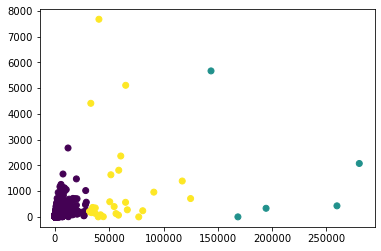

In [752]:
X = dfc[['revenue', 'frequency']].to_numpy()      
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)    #revenues

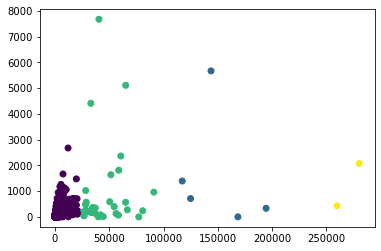

In [753]:
X = dfctwo[['revenue', 'frequency']].to_numpy()      
y_pred2 = KMeans(n_clusters=4, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred2)    #revenues

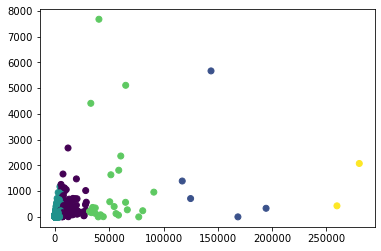

In [918]:
X = dfcthree[['revenue', 'frequency']].to_numpy()      
y_pred3 = KMeans(n_clusters=5, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred3)    #revenues

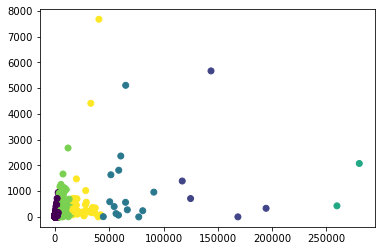

In [635]:
X = dfcfour[['revenue', 'frequency']].to_numpy()      
y_pred4 = KMeans(n_clusters=6, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred4)    #revenues

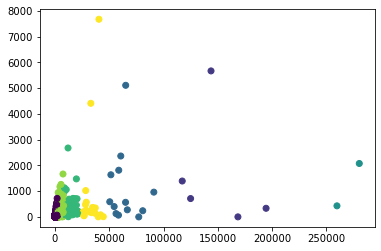

In [636]:
X = dfcfive[['revenue', 'frequency']].to_numpy()      
y_pred5 = KMeans(n_clusters=7, random_state=42).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred5)    #revenues

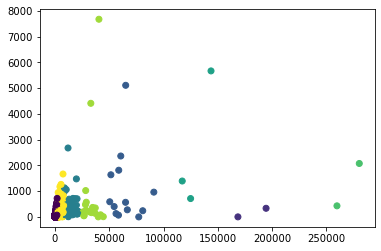

In [91]:
X = dfcsix[['revenue', 'frequency']].to_numpy()      
y_pred6 = KMeans(n_clusters=8, random_state=42).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred6)    #revenues

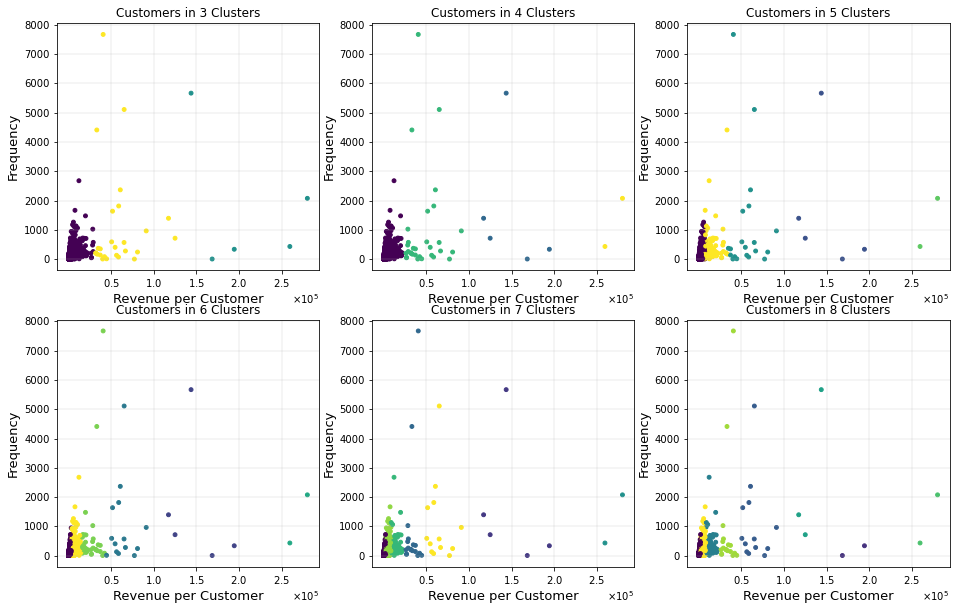

In [92]:
fig, ((ax1, ax2, ax3), (axs4, axs5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,  figsize=(16, 10))

ax1 = plt.subplot2grid((2,3),(0, 0))
ax1.scatter(dfc['revenue'], dfc['frequency'], c=y_pred, s=15)
ax1.set_title('Customers in 3 Clusters')
ax1.set_xlabel('Revenue per Customer', fontsize=13)
ax1.set_ylabel('Frequency', fontsize=13)
ax1.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax1.xaxis.set_major_formatter(formatter) 
ax1.grid(linewidth=0.25)


ax2 = plt.subplot2grid((2,3),(0, 1))
ax2.scatter(dfctwo['revenue'], dfctwo['frequency'], c=y_pred2, s=15)
ax2.set_title('Customers in 4 Clusters')
ax2.set_xlabel('Revenue per Customer', fontsize=13)
ax2.set_ylabel('Frequency', fontsize=13)
ax2.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax2.xaxis.set_major_formatter(formatter) 
ax2.grid(linewidth=0.25)

ax3 = plt.subplot2grid((2,3),(0, 2))
ax3.scatter(dfcthree['revenue'], dfcthree['frequency'], c=y_pred3, s=15)
ax3.set_title('Customers in 5 Clusters')
ax3.set_xlabel('Revenue per Customer', fontsize=13)
ax3.set_ylabel('Frequency', fontsize=13)
ax3.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax3.xaxis.set_major_formatter(formatter) 
ax3.grid(linewidth=0.25)

ax4 = plt.subplot2grid((2,3),(1, 0))
ax4.scatter(dfcfour['revenue'], dfcfour['frequency'], c=y_pred4, s=15)
ax4.set_title('Customers in 6 Clusters')
ax4.set_xlabel('Revenue per Customer', fontsize=13)
ax4.set_ylabel('Frequency', fontsize=13)
ax4.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax4.xaxis.set_major_formatter(formatter) 
ax4.grid(linewidth=0.25)

ax5 = plt.subplot2grid((2,3),(1, 1))
ax5.scatter(dfcfive['revenue'], dfcfive['frequency'], c=y_pred5, s=15)
ax5.set_title('Customers in 7 Clusters')
ax5.set_xlabel('Revenue per Customer', fontsize=13)
ax5.set_ylabel('Frequency', fontsize=13)
ax5.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax5.xaxis.set_major_formatter(formatter) 
ax5.grid(linewidth=0.25)

ax6 = plt.subplot2grid((2,3),(1, 2))
ax6.scatter(dfcsix['revenue'], dfcsix['frequency'], c=y_pred6, s=15)
ax6.set_title('Customers in 8 Clusters')
ax6.set_xlabel('Revenue per Customer', fontsize=13)
ax6.set_ylabel('Frequency', fontsize=13)
ax6.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax6.xaxis.set_major_formatter(formatter) 
ax6.grid(linewidth=0.25)

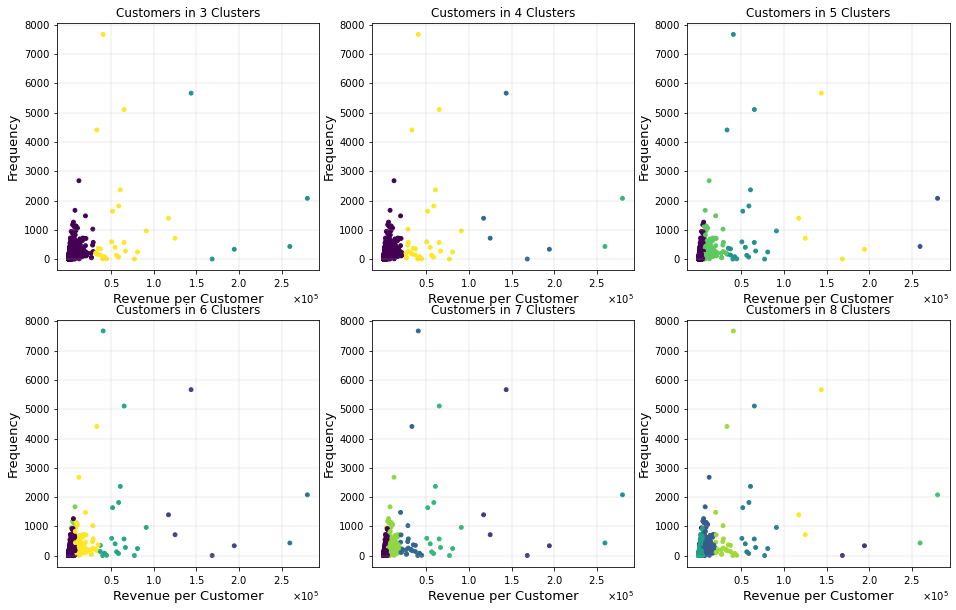

In [93]:
# DOUBLE CHECKING IF ABOVE PLOTS ARE CONSISTENT WHEN CLUSTERNO IS USED INSTEAD OF Y_PRED-- GOOD THAT IT PRODUCES SAME PLOTS

fig, ((ax1, ax2, ax3), (axs4, axs5, ax6)) = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True,  figsize=(16, 10))

ax1 = plt.subplot2grid((2,3),(0, 0))
ax1.scatter(dfc['revenue'], dfc['frequency'],  c=dfc.ClusterNo, s=15)
ax1.set_title('Customers in 3 Clusters')
ax1.set_xlabel('Revenue per Customer', fontsize=13)
ax1.set_ylabel('Frequency', fontsize=13)
ax1.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax1.xaxis.set_major_formatter(formatter) 
ax1.grid(linewidth=0.25)


ax2 = plt.subplot2grid((2,3),(0, 1))
ax2.scatter(dfctwo['revenue'], dfctwo['frequency'], c=dfctwo.ClusterNo, s=15)
ax2.set_title('Customers in 4 Clusters')
ax2.set_xlabel('Revenue per Customer', fontsize=13)
ax2.set_ylabel('Frequency', fontsize=13)
ax2.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax2.xaxis.set_major_formatter(formatter) 
ax2.grid(linewidth=0.25)

ax3 = plt.subplot2grid((2,3),(0, 2))
ax3.scatter(dfcthree['revenue'], dfcthree['frequency'], c=dfcthree.ClusterNo, s=15)
ax3.set_title('Customers in 5 Clusters')
ax3.set_xlabel('Revenue per Customer', fontsize=13)
ax3.set_ylabel('Frequency', fontsize=13)
ax3.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax3.xaxis.set_major_formatter(formatter) 
ax3.grid(linewidth=0.25)

ax4 = plt.subplot2grid((2,3),(1, 0))
ax4.scatter(dfcfour['revenue'], dfcfour['frequency'], c=dfcfour.ClusterNo, s=15)
ax4.set_title('Customers in 6 Clusters')
ax4.set_xlabel('Revenue per Customer', fontsize=13)
ax4.set_ylabel('Frequency', fontsize=13)
ax4.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax4.xaxis.set_major_formatter(formatter) 
ax4.grid(linewidth=0.25)

ax5 = plt.subplot2grid((2,3),(1, 1))
ax5.scatter(dfcfive['revenue'], dfcfive['frequency'], c=dfcfive.ClusterNo, s=15)
ax5.set_title('Customers in 7 Clusters')
ax5.set_xlabel('Revenue per Customer', fontsize=13)
ax5.set_ylabel('Frequency', fontsize=13)
ax5.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax5.xaxis.set_major_formatter(formatter)
ax5.grid(linewidth=0.25)

ax6 = plt.subplot2grid((2,3),(1, 2))
ax6.scatter(dfcsix['revenue'], dfcsix['frequency'], c=dfcsix.ClusterNo, s=15)
ax6.set_title('Customers in 8 Clusters')
ax6.set_xlabel('Revenue per Customer', fontsize=13)
ax6.set_ylabel('Frequency', fontsize=13)
ax6.set_xticks([50000, 100000, 150000, 200000, 250000])
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax6.xaxis.set_major_formatter(formatter) 
ax6.grid(linewidth=0.25)

In [94]:
dfc.head()

,CustomerID,revenue,frequency,daysprior,ClusterNo
0,12346.0,77183.60,1,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


ClusterNo
0    4120
1       2
2      22
3     189
4       5
dtype: int64

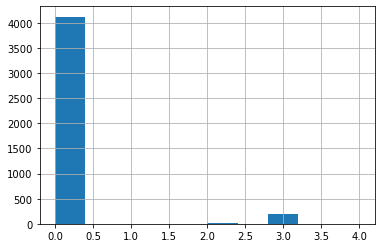

In [95]:
dfcthree.ClusterNo.hist()
dfcthreeGB = dfcthree.groupby(["ClusterNo"]).size()
dfcthreeGB

In [96]:
X[:, 0]  #revenue per customer

array([77183.6 ,  4310.  ,  1797.24, ...,   178.05,  2045.53,  1837.28])

In [97]:
X[:, 1]  #freq per customer

array([  1., 182.,  31., ...,  12., 721.,  70.])

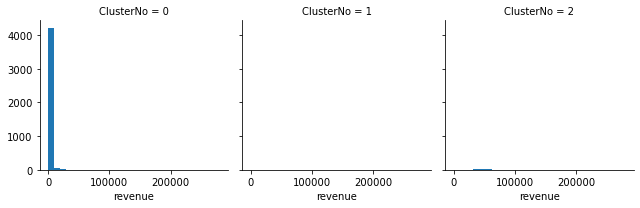

In [98]:
g = sns.FacetGrid(dfc, col='ClusterNo')
g.map(plt.hist, 'revenue', bins=3)

<AxesSubplot:xlabel='ClusterNo', ylabel='revenue'>

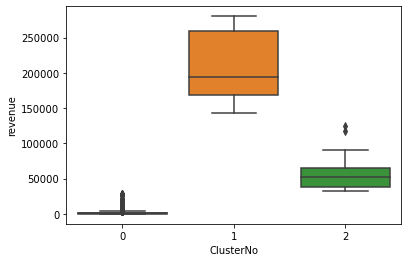

In [99]:
sns.boxplot(x='ClusterNo', y='revenue', data=dfc)

<AxesSubplot:xlabel='ClusterNo', ylabel='revenue'>

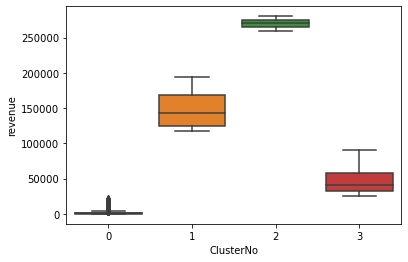

In [100]:
sns.boxplot(x='ClusterNo', y='revenue', data=dfctwo)

<AxesSubplot:xlabel='ClusterNo', ylabel='revenue'>

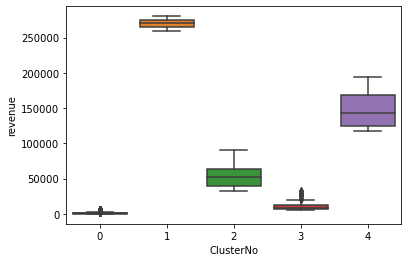

In [107]:
sns.boxplot(x='ClusterNo', y='revenue', data=dfcthree)

sns.boxplot(x='ClusterNo', y='revenue', data=dfcthree)

<AxesSubplot:xlabel='ClusterNo', ylabel='frequency'>

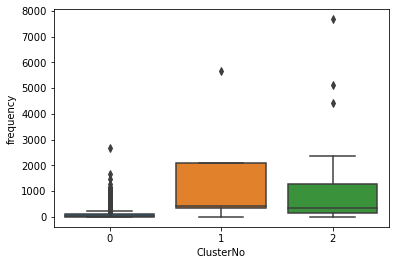

In [101]:
sns.boxplot(x='ClusterNo', y='frequency', data=dfc)

<AxesSubplot:xlabel='ClusterNo', ylabel='frequency'>

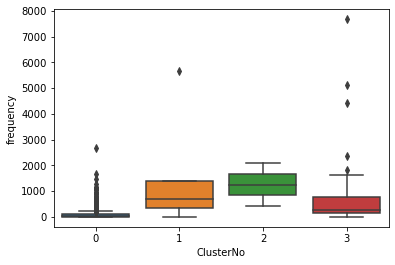

In [102]:
sns.boxplot(x='ClusterNo', y='frequency', data=dfctwo)

In [103]:
corr=dfc[['revenue', 'frequency', 'daysprior', 'CustomerID']].corr()
corr

,revenue,frequency,daysprior
revenue,1.000000,0.425282,-0.121831
frequency,0.425282,1.000000,-0.206444
daysprior,-0.121831,-0.206444,1.000000


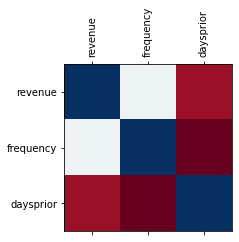

In [104]:
fig=plt.figure(figsize=(3,3))
plt.matshow(corr, cmap='RdBu', fignum=fig.number)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
plt.yticks(range(len(corr.columns)), corr.columns);

sns.swarmplot(x='ClusterNo',y='revenue',data=dfc)
plt.xlabel('ClusterNo')
plt.ylabel('revenue')
plt.show()

sns.swarmplot(x='ClusterNo',y='revenue',data=dfctwo)
plt.xlabel('ClusterNo')
plt.ylabel('revenue')
plt.show()

sns.swarmplot(x='ClusterNo',y='revenue',data=dfctfive)
plt.xlabel('ClusterNo')
plt.ylabel('revenue')
plt.show()

sns.swarmplot(x='ClusterNo',y='revenue',data=dfcsix)
plt.xlabel('ClusterNo')
plt.ylabel('revenue')
plt.show()

SECOND ANALYSIS -NON-ML TO VALIDATE ML RESULTS???

In [843]:
dfcsecondanalysis.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


X = dfcsecondanalysis[['revenue', 'frequency', 'daysprior']].to_numpy()      
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)  
dfcsecondanalysis.head()

kmeans = KMeans(n_clusters=5, random_state=42, max_iter=50)
kmeans.fit(dfcsecondanalysis)
kmeans.labels_
#assign created labels as ClusterNo
dfcsecondanalysis['ClusterNo'] = kmeans.labels_
dfcsecondanalysis.head(2)

In [844]:
recency1 = (datetime(2010, 12, 1) - df.groupby("CustomerID").agg({"InvoiceDate":"max"})).rename(columns = {"InvoiceDate":"Recency"})

In [845]:
freq1 = df.groupby("CustomerID").agg({"InvoiceDate":"nunique"}).rename(columns={"InvoiceDate": "Frequency"})

Can we draw Empirical cumulative distribution functions (ECDFs)for 3 customer clusters in the same chart?
    


In [846]:
dfcsecondanalysis.head()

,CustomerID,revenue,frequency,daysprior
0,12346.0,77183.60,1,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [847]:
dfcsecondanalysis["Recencycategory"] = pd.qcut(dfcsecondanalysis["daysprior"], 5, labels = [5, 4 , 3, 2, 1])
dfcsecondanalysis["Frequencycategory"]= pd.qcut(dfcsecondanalysis["frequency"].rank(method="first"),5, labels=[1,2,3,4,5])
dfcsecondanalysis["Revenuecategory"] = pd.qcut(dfcsecondanalysis['revenue'], 5, labels = [1, 2, 3, 4, 5])
dfcsecondanalysis.head()

,CustomerID,revenue,frequency,daysprior,Recencycategory,Frequencycategory,Revenuecategory
0,12346.0,77183.60,1,325,1,1,5
1,12347.0,4310.00,182,1,5,5,5
2,12348.0,1797.24,31,74,2,3,4
3,12349.0,1757.55,73,18,4,4,4
4,12350.0,334.40,17,309,1,2,2


In [848]:
dfcsecondanalysis["RFR_SCORE"] = (dfcsecondanalysis["Recencycategory"].astype(str) + 
                     dfcsecondanalysis["Frequencycategory"].astype(str) + 
                     dfcsecondanalysis["Revenuecategory"].astype(str))
dfcsecondanalysis.head()

,CustomerID,revenue,frequency,daysprior,Recencycategory,Frequencycategory,Revenuecategory,RFR_SCORE
0,12346.0,77183.60,1,325,1,1,5,115
1,12347.0,4310.00,182,1,5,5,5,555
2,12348.0,1797.24,31,74,2,3,4,234
3,12349.0,1757.55,73,18,4,4,4,444
4,12350.0,334.40,17,309,1,2,2,122


In [874]:
seg_map = {
    r'[1-3][1-3][1-2]': 'IGNORE',
    r'[3-5][1-3][1-2]': 'IGNORE',
    
    r'[1-3][1-5][2-5]': 'STIMULATE',
    r'[1-3][3-5][1-2]': 'STIMULATE',
    r'[3-5][1-3][2-5]': 'WELCOME',
    
    r'[3-5][3-5][1-2]': 'Silver-REWARD',
    r'[3-5][3-5][2-5]': 'REWARD'
 
}

dfcsecondanalysis['Segment'] = dfcsecondanalysis['Recencycategory'].astype(str) + dfcsecondanalysis['Frequencycategory'].astype(str)+ dfcsecondanalysis['Revenuecategory'].astype(str)
dfcsecondanalysis['Segment'] = dfcsecondanalysis['Segment'].replace(seg_map, regex=True)

In [875]:
dfcsecondanalysis.head(10)

,CustomerID,revenue,frequency,daysprior,Recencycategory,Frequencycategory,Revenuecategory,RFR_SCORE,Segment
0,12346.0,77183.60,1,325,1,1,5,115,STIMULATE
1,12347.0,4310.00,182,1,5,5,5,555,REWARD
2,12348.0,1797.24,31,74,2,3,4,234,STIMULATE
3,12349.0,1757.55,73,18,4,4,4,444,REWARD
4,12350.0,334.40,17,309,1,2,2,122,IGNORE
5,12352.0,2506.04,85,35,3,4,5,345,STIMULATE
6,12353.0,89.00,4,203,1,1,1,111,IGNORE
7,12354.0,1079.40,58,231,1,4,4,144,STIMULATE
8,12355.0,459.40,13,213,1,1,2,112,IGNORE
9,12356.0,2811.43,59,22,4,4,5,445,REWARD


In [931]:
dfcsecondanalysis['Segment'].value_counts()

IGNORE           1606
STIMULATE        1300
REWARD           1050
WELCOME           332
Silver-REWARD      50
Name: Segment, dtype: int64

In [876]:
dfsa = dfcsecondanalysis.groupby(["Segment"]).size()
dfsa
type(dfsa)

pandas.core.series.Series

Text(0.5, 0, 'Marketing Clusters')

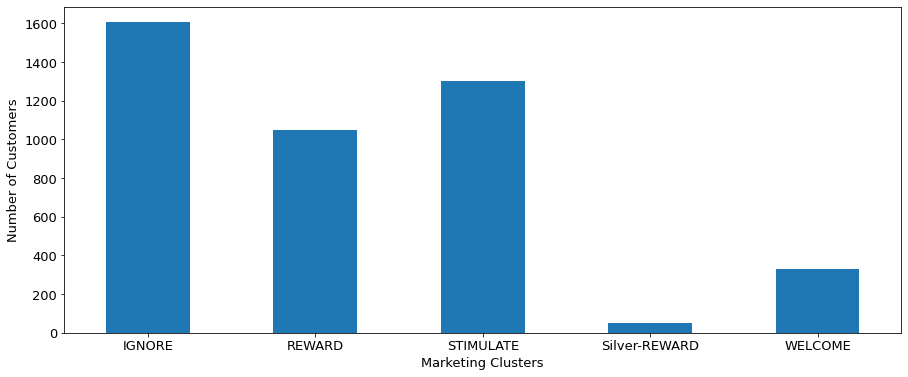

In [877]:
ax = dfsa.plot.bar(x='Segment', rot=0, figsize=(15, 6), fontsize=13)
ax.set_ylabel('Number of Customers', fontsize=13)
ax.set_xlabel('Marketing Clusters', fontsize=13)

C:\Users\banut\anaconda3\envs\tf\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 81.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\banut\anaconda3\envs\tf\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 99.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


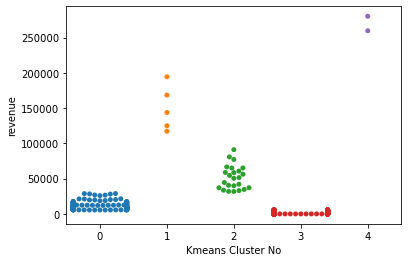

In [760]:
#Swarmplot is not good since it does not show majority of data points
#kmeans clustering with 5 clusters
sns.swarmplot(x='ClusterNo',y='revenue',s=5, data=dfcthree)
plt.xlabel('Kmeans Cluster No')
plt.ylabel('revenue')
plt.show()

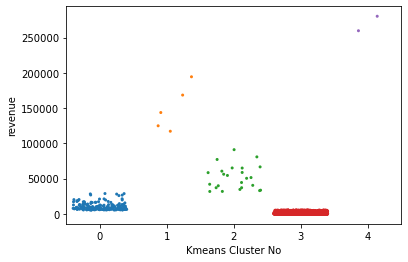

In [915]:
#kmeans clustering with 5 clusters
sns.stripplot(x='ClusterNo',y='revenue',s=3, data=dfcthree, jitter=0.4)
plt.xlabel('Kmeans Cluster No')
plt.ylabel('revenue')
plt.show()

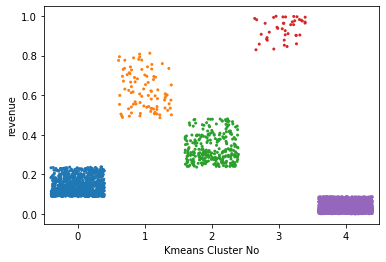

In [923]:
#kmeans clustering with 5 clusters using normalized data
sns.stripplot(x='ClusterNo',y='revenue',s=3, data=dfcthree2, jitter=0.4)
plt.xlabel('Kmeans Cluster No')
plt.ylabel('revenue')
plt.show()


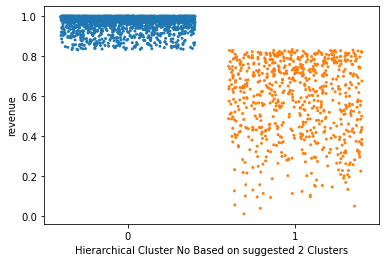

In [916]:
#Hierarchical clustering with 2 clusters as originally suggested
sns.stripplot(x='Hierarchical_customer_labels',y='revenue', s=3, data=dfcthirdanalysis, jitter=0.4)
plt.xlabel('Hierarchical Cluster No Based on suggested 2 Clusters')
plt.ylabel('revenue')
plt.show()



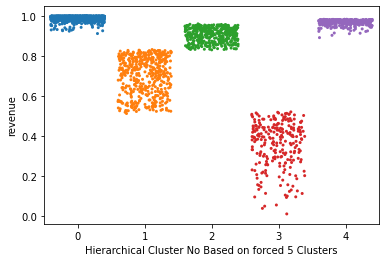

In [913]:
#Hierarchical clustering forced with 5 clusters
sns.stripplot(x='Hierarchical_customer_labels',y='revenue', s=3, data=dfcthirdanalysis2, jitter=0.4)
plt.xlabel('Hierarchical Cluster No Based on forced 5 Clusters')
plt.ylabel('revenue')
plt.show()



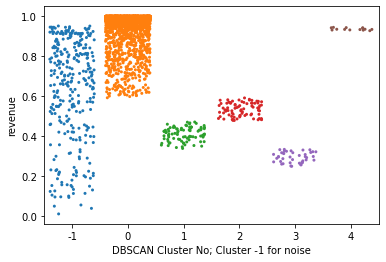

In [912]:
#DBSCAN clustering with calculated eps
sns.stripplot(x='dbscan_cluster',y='revenue',s=3,  data=dfcs4thanalysis, jitter=0.4)
plt.xlabel('DBSCAN Cluster No; Cluster -1 for noise')
plt.ylabel('revenue')
plt.show()


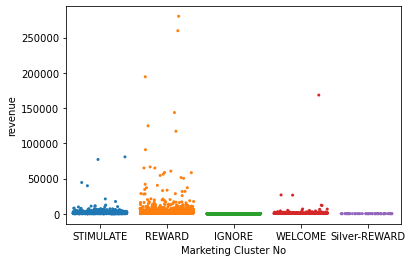

In [917]:
#non-AI business perspective clustering 
sns.stripplot(x='Segment',y='revenue', s=3, data=dfcsecondanalysis, jitter=0.4)
plt.xlabel('Marketing Cluster No')
plt.ylabel('revenue')
plt.show()